# REopt–OpenDSS Linkage Demo

To get started, select "Cell", "Run All" from the menu above.  Basic plots can be generated by selecting different values from the lists generated below. To change output filenames, input or output locations, or more advanced plotting options, feel free to toggle the code visibility and access the appropriate lines of code.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle code visibility (hidden for clarity)."></form>''')


In [5]:
import time
from ipywidgets import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import ipython_blocking # enables %block and %blockrun magic

# ================================================================
# 1. Create the run selection widget
# ================================================================

# Create a list of runs from all runs in the NAERM/runs directory:
run_list = [('None Selected',1),
             ('13Bus',2), 
             ('34Bus',3), 
             ('123 Bus',4),
             ('IEEE 30 Bus',5)]

# Base run selector-----------------
run_selector_dropdown_base = widgets.Dropdown(
    options=run_list,
    value=1,
)
run_selector_upload_base = widgets.FileUpload(
    accept='.dss,.DSS,.csv',
    multiple=True  # True to accept multiple files upload else False
)

# Create the accordion expander things for each tab:
accordion_base = widgets.Accordion(children=[run_selector_dropdown_base, run_selector_upload_base])
accordion_base.set_title(0, """Select one of OpenDSS's test networks""")
accordion_base.set_title(1, 'Or select any network with your file explorer')

# Comparison run selector----------------
run_selector_dropdown_comp = widgets.Dropdown(
    options=run_list,
    value=1,
)
run_selector_upload_comp = widgets.FileUpload(
    accept='.dss,.DSS,.csv', 
    multiple=False  # True to accept multiple files upload else False
)

# Create the accordion expander things for each tab:
accordion_comp = widgets.Accordion(children=[run_selector_dropdown_comp, run_selector_upload_comp])
accordion_comp.set_title(0, """Select one of OpenDSS's test networks""")
accordion_comp.set_title(1, 'Or select any network with your file explorer')

# Combine them together in tabs for display-----------
run_selector_tabs = widgets.Tab()
run_selector_tabs.children = [ accordion_base, accordion_comp]
run_selector_tabs.set_title(0,"Base run")
run_selector_tabs.set_title(1,"Comparison run")

button = widgets.Button(description='Proceed')
button.disabled = True

# Disable the "Proceed" button until a run has been chosen:
def validation(ev):
    "make button clickable if user has chosen a run"
    if (run_selector_dropdown_base.value > 1 and accordion_base.selected_index == 0) or (run_selector_upload_base.value and accordion_base.selected_index == 1):
        #print(accordion_base.selected_index)
        button.disabled = False
    else:
        button.disabled = True
run_selector_dropdown_base.observe(validation)
run_selector_upload_base.observe(validation)
accordion_base.observe(validation)

box = widgets.VBox(children=[run_selector_tabs, button])
display(box)


#Wait for the user to click the button before proceeding with the values selected in the widget
%blockrun button


ModuleNotFoundError: No module named 'ipython_blocking'

In [4]:
# Set the run according to which accordion the user has open:
if accordion_base.selected_index == 0: #use the value from the dropdown
    filename_base = run_list[run_selector_dropdown_base.value - 1][0]
else: #use the value from the file upload
    filename_base = list(run_selector_upload_base.value.keys())[0]
    
filename_base = os.path.splitext(os.path.basename(filename_base))

In [5]:
from h5plexos.process import process_solution
import time
import os.path
from sklearn.linear_model import LinearRegression #for loading bar
import threading #for updating progress bar as h5 file is built

# NOTE: Run this cell only once to generate the .h5 file from the 
# PLEXOS .zip output.  Changing plotted values can be done without
# re-evaluating this cell
filename_base = 'Model Q1 2 Week DA Base Solution'
baserun_zip_name = '../%s.zip' % (filename_base)
baserun_h5_name = '%s.h5' % (filename_base)

# ================================================================
# 1. Implement a progress bar for the HDF5 creation
# ================================================================
# Record the zip and h5 sizes (in MB) of a bunch of databases to add to a regression for a loading bar:
baserun_zip_size = os.path.getsize(baserun_zip_name) >> 20 #bitshift by 20 to approximate MB

zip_sizes = np.array([1.5,132.0]).reshape(-1,1)
h5_sizes =  np.array([4.0,186.8])
linleastsq = LinearRegression().fit(zip_sizes,h5_sizes)
h5_size_prediction = linleastsq.predict(np.array([baserun_zip_size]).reshape(1,-1))

# Build and display the bar:
progbar = widgets.FloatProgress(
    min=0,
    max=h5_size_prediction,
    step=0.1,
    description='',
    bar_style='info',
    orientation='horizontal'
)
print('Expected h5 file size: ' + str(h5_size_prediction))
prog = widgets.HBox(children=[widgets.HTML(value='Creating HDF5 file for analysis:'), progbar])


# Update the progbar as the file is processed:
def update_progbar(progbar, stopper):
    while not stopper.is_set():
        try:
            progbar.value = os.path.getsize(baserun_h5_name) >> 20 #bitshift by 20 to approximate MB
        except:
            #print('ok excepted')
            time.sleep(0.001)
    print(progbar.value)
    #print('hi, observing')

stopper = threading.Event()
thread = threading.Thread(target=update_progbar, args=(progbar,stopper))
display(prog)
thread.start()

# ================================================================
# 2. Create an h5plexos file for the run if it hasn't been created 
# ================================================================
if os.path.isfile('%s.h5' % (filename_base)):
    print('Found an existing .h5 file for %s.zip.' % (filename_base))
    print('No conversion necessary.')
else:
    try:
        os.path.isfile('../%s.zip' % (filename_base))
    except:
        raise ValueError('No file at ../%s.zip' % (filename_base))
    else:
        print('Converting PLEXOS Solution to hdf5... ', end='')

        t1 = time.time()
        # process_solution("Input_File.zip", "Output_File.h5")
        input_file = '../%s.zip' % (filename_base)
        output_file = '%s.h5' % (filename_base)
        process_solution(input_file, output_file)
        t2 = time.time()

        print('Finished converting')
        print('Saved to %s' % (output_file))
        print('Elapsed Time: %.1f s' % (t2 - t1))

print(os.path.getsize(baserun_h5_name) >> 20)

stopper.set()
print('donezo')


Expected h5 file size: [3.29961686]


Found an existing .h5 file for Model Q1 2 Week DA Base Solution.zip.
No conversion necessary.
3
donezo
3.0


In [6]:
import threading #for 
from IPython.display import display
import time
progress = widgets.FloatProgress(value=0.0, min=0.0, max=1.0)

def work(progress):
    total = 100
    for i in range(total):
        time.sleep(0.2)
        progress.value = float(i+1)/total

thread = threading.Thread(target=work, args=(progress,))
display(progress)
thread.start()

FloatProgress(value=0.0, max=1.0)

<IPython.core.display.Javascript object>


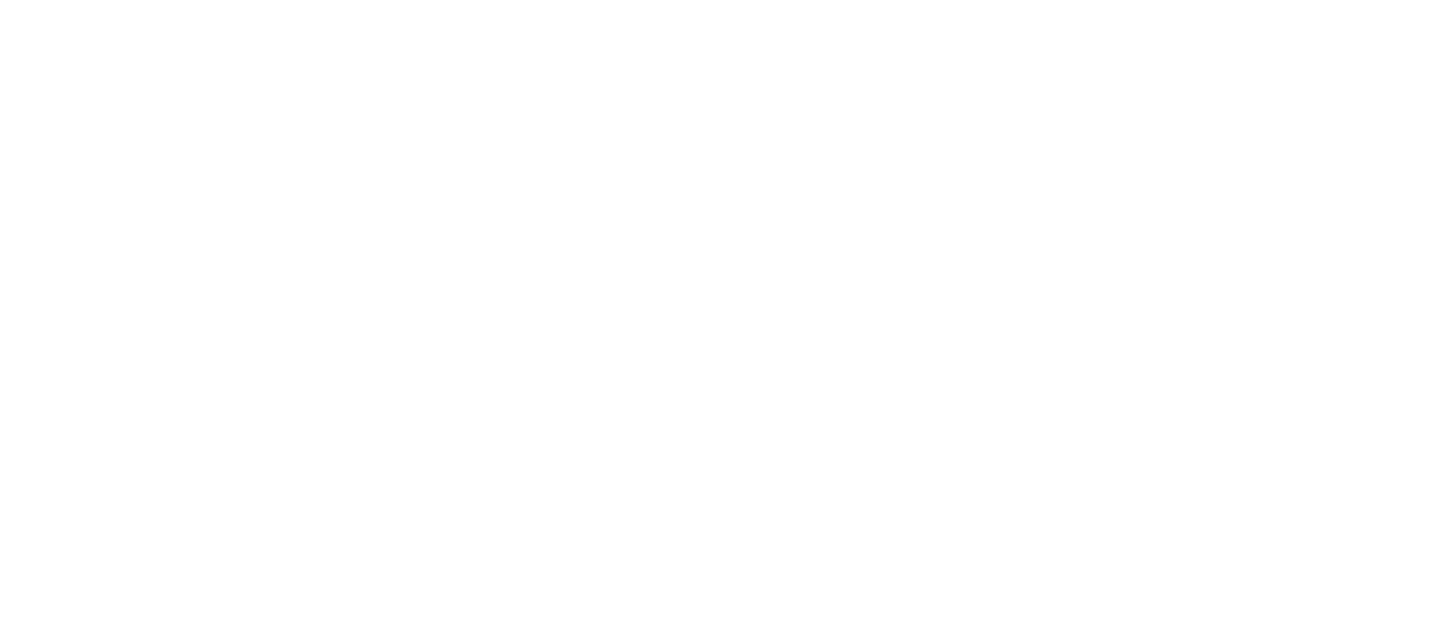

Button(description='Save Figure.', style=ButtonStyle(), tooltip='Save the currently-displayed figure into the …

Output()

Checkbox(value=False, description='Overlay Mean')

<IPython.core.display.Javascript object>


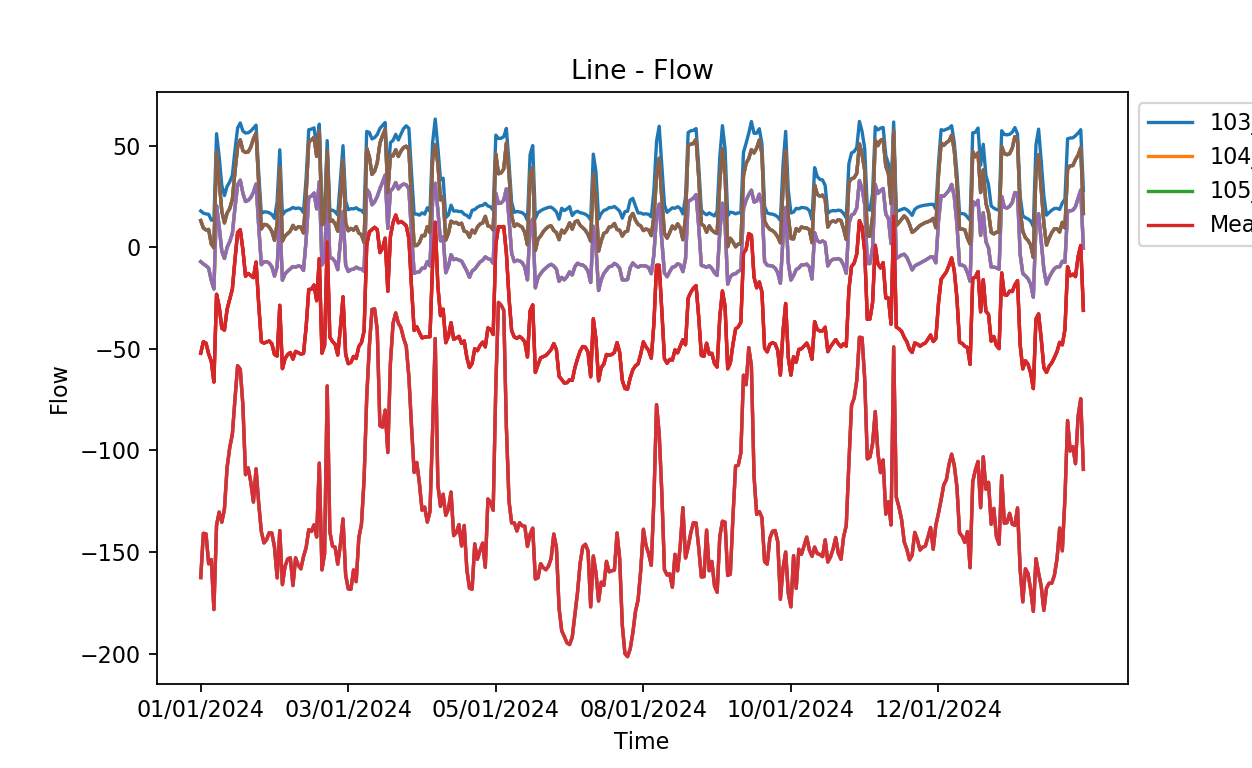

In [7]:
%matplotlib notebook

# ================================================================
# Initially, build the list of object -> property relationships
# and get timesteps labels for the data
# ================================================================

root_data_path = '/data/ST/interval/'
root_meta_path = '/metadata/objects/'
root_time_path = '/metadata/times/interval/'

with PLEXOSSolution('%s.h5' % filename_base) as db:
    # Initialize a blank list for the timesteps
    timestamps = []
    
    # Build the list with every timestep value
    for key in db.h5file[root_time_path]:
        timestamps.append(key.decode('UTF-8')[0:10])
        
    tSteps = len(timestamps)
        
    # Initialize blank lists for classes, properties, and objects
    class_list = []
    property_list_total = []
    object_list_total = []

    # For every class in this file
    for key in db.h5file[root_data_path]:
        class_list.append(key)
        
        # Build property list for the kth class
        property_list = []
        data_path = ('%s%s/' % (root_data_path, key))
        
        try:
            db.h5file[data_path]
        except:
            print('Warning: Nothing found at %s' % (data_path))
            property_list.append('NA')
        else:
            for property_key in db.h5file[data_path]:
                property_list.append(property_key)

        # Append this single list to the cummulative one
        property_list_total.append(property_list)
            
        # Build object list for the kth class
        object_list = []
        meta_path = ('%s%s/' % (root_meta_path, key))
        
        try:
            db.h5file[meta_path]
        except:
            print('Warning: Nothing found at %s' % (meta_path))
            object_list.append('NA')
        else:
            for object_key in db.h5file[meta_path]:
                object_list.append(object_key[0].decode('UTF-8'))

        # Append this single list to the cumulative one
        object_list_total.append(object_list)

# ================================================================
# 1. Create the class selection widget
# ================================================================

w1 = widgets.Select(
    options = class_list,
    rows = len(class_list) + 1,
    disabled = False
)

# Define what happens when widget 1 changes
def w1_action(*args):
    # Get the index of the selected class
    s = w1.index

    # Change widget 2 options
    w2.options = property_list_total[s]
    w2.rows = len(property_list_total[s]) + 1
    w2.disabled = False
    
    # Change widget 3 options
    w3.options = object_list_total[s]
    w3.rows = len(object_list_total[s]) + 1
    w3.disabled = True
    
    # Clear the axis if a new class is selected    
    ax.cla()

# ================================================================
# 2. Create the property selection widget
# ================================================================

w2 = widgets.Select(
    options = property_list_total[0],
    rows = len(property_list_total[0]) + 1,
    disabled = True
)

# Define what happens when widget 2 changes
def w2_action(*args):
    data_path = '%s%s/%s' % (root_data_path, w1.value, w2.value)    

    with PLEXOSSolution('%s.h5' % filename_base) as db:
        try:
            db.h5file[data_path]
        except:
            print('Nothing found at %s' % (data_path))
        else:
            global data_array
            
            for ctr, key in enumerate(db.h5file[data_path]):
                if ctr == 0:
                    data_array = np.array(key)
                else:
                    data_array = np.hstack((data_array, key))

    # Clear the axis if a new property of the same class is selected
    ax.cla()
    
    # Unlock the object selection widget
    w3.disabled = False
    
    # Clear the "overlay mean" option
    w4.value = False
    
# ================================================================
# 3. Create the plot selection
# ================================================================

w3 = widgets.SelectMultiple(
    options = object_list_total[0],
    rows = len(object_list_total[0]) + 1,
    disabled = True
)

# Define what happens when widget 3 changes
def w3_action(*args):

    # Clear the axes before every refresh
    ax.cla()
    
    # Clear the "overlay mean" option
    w4.value = False

    if len(w3.index) > 0:
        # Plot only the selected data
        plt.plot(np.arange(tSteps), data_array[:, w3.index])
        
        # Set the x-labels
        xLabelNum = 6
        gap = np.int(np.ceil(tSteps/xLabelNum))
        xlabels = timestamps[::gap]
        plt.xticks(np.arange(0, tSteps, gap), xlabels)
        plt.xlabel('Time')
        
        # Set the y-labels
        plt.ylabel(('%s' % (w2.value)).title())

        # Create the legend
        plt.legend(w3.value, loc = 'upper left', bbox_to_anchor = (1, 1))
        
        # Create the title
        plt.title(('%s - %s' % (w1.value, w2.value)).title())
      
    
# ================================================================
# 4. Create the mean time series overlay selection
# ================================================================
  
w4 = widgets.Checkbox(
    value = False,
    description = 'Overlay Mean',
    tooltip = 'Compute the time-varying mean of the selected vaues and overlay the curve on the data.',
    disabled = False
)

# Define what happens when widget 4 changes
def w4_action(*args):

    # Clear the axes before every refresh
    ax.cla()
    
    if w4.value == True:
        if len(w3.index) > 0:
            # Plot only the selected data
            gray = (0.75, 0.75, 0.75)
            plt.plot(np.arange(tSteps), data_array[:, w3.index], alpha = 0.1)
            plt.plot(np.arange(tSteps), np.mean(data_array[:, w3.index], axis = 1), color = 'C3')

            # Set the x-labels
            xLabelNum = 6
            gap = np.int(np.ceil(tSteps/xLabelNum))
            xlabels = timestamps[::gap]
            plt.xticks(np.arange(0, tSteps, gap), xlabels)
            plt.xlabel('Time')

            # Set the y-labels
            plt.ylabel(('%s' % (w2.value)).title())

            # Create the legend
            plt.legend((*w3.value, 'Mean'), loc = 'upper left', bbox_to_anchor = (1, 1))

            # Create the title
            plt.title(('%s - %s' % (w1.value, w2.value)).title())
    else:
        w3_action()


# ================================================================
# 5. Create the line vs. stack plot toggle buttons:
# ================================================================
w_plot_type = widgets.ToggleButtons(
    options=['Line', 'Stacked'],
    description='Plot Type:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Create typical line plot', 'Create a stacked dispatch plot'],
#     icons=['check'] * 3
)

# ================================================================
# 6. Display widgets and wait for changes
# ================================================================

# Arrange the data selectors side-by-side:
w1_w_title = widgets.VBox([widgets.HTML(value="<big><b>1. Class</b></big>"), 
                           HBox([w1], layout=Layout(height='240px', overflow_y='auto'))])
w2_w_title = widgets.VBox([widgets.HTML(value="<big><b>2. Property</b></big>"),
                           HBox([w2], layout=Layout(height='240px', overflow_y='auto'))])
w3_w_title = widgets.VBox([widgets.HTML(value="<big><b>3. Object(s)</b></big>"),
                           HBox([w3], layout=Layout(height='240px', overflow_y='auto'))])
w_data_selector = widgets.HBox([w1_w_title,w2_w_title,w3_w_title])
display(w_data_selector)

print('\n')

w1.observe(w1_action, 'value')
w2.observe(w2_action, 'value')
w3.observe(w3_action, 'value')

print('\n')

#display(w_plot_type)

# Create the figure and axis handle
fig = plt.figure(figsize=(9, 4), dpi=100, linewidth=20)
left = 0.1
bottom = 0.1 
width = 0.7
height = 0.8
ax = fig.add_axes([left, bottom, width, height])

plt.show()

# Create a button to manually save the currently displayed figure
save_button = widgets.Button(
    description = 'Save Figure.',
    tooltip = 'Save the currently-displayed figure into the ./saved_plots directory.'
)

save_button_output = widgets.Output()

display(save_button, save_button_output)

def save_button_action(b):
    with save_button_output:
        current = datetime.datetime.now()
        plt.savefig(('saved_plots/plexos_output_%s.png' % current), format='png', dpi=200)
        
save_button.on_click(save_button_action)

display(w4)
w4.observe(w4_action, 'value')


## Performance, Reliability, and Resilitence Metrics

In [412]:
%load_ext autoreload
%autoreload 2
from metrics import NAERM_PLEXOS_Metrics
import h5py
import numpy as np

# Output metrics to the dashboard:
#NAERM_PLEXOS_Metrics('%s.h5' % filename_base)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [413]:
# Date ranges
event_start = "2024-01-03 02:00:00"
event_stop  = "2024-01-06 22:00:00"

# Regions of Interest
regions = ["ISONE_EI","NYISO_EI"]
#regions = "1"
#region_2 = "NYISO_EI"

# Standard Generation Order
ordered_gen = ['Nuclear',
               'Coal',
               'Gas-CC',
               'Gas-CT',
               'Gas',
               'Gas-Steam',
               'Dual Fuel',
               'Oil-Gas-Steam',
               'Oil',
               'Hydro',
               'Ocean', 
               'Geothermal',
               'Biomass',
               'Biopower',
               'Other',
               'Wind',
               'Solar',
               'CSP',
               'PV',
               'Storage',
               'Net Imports']

# Standard Naming of Data
gen_names = {'Nuclear_EI': 'Nuclear',
             'Nuclear_ERCOT': 'Nuclear',
             'Nuclear_MX': 'Nuclear',
             'Nuclear_WI': 'Nuclear',
             'nuclear':'Nuclear',
             'Coal_ST_EI': 'Coal',
             'Coal_ST_ERCOT': 'Coal',
             'Coal_ST_MX': 'Coal',
             'Coal_ST_WI': 'Coal',
             'coal-igcc':'Coal',
             'coal-new':'Coal',
             'coaloldscr':'Coal',
             'coal-ccs' : 'Coal',
             'NG_CC_EI': 'Gas-CC',
             'NGCC_MX': 'Gas-CC',
             'Gas CC_ERCOT': 'Gas-CC',
             'CC_WI':'Gas-CC',
             'gas-cc':'Gas-CC',
             'NG_CT_EI': 'Gas-CT',
             'CT_WI': 'Gas-CT',
             'Gas_CT_ERCOT': 'Gas-CT',
             'NGCT_MX': 'Gas-CT',
             'gas-ct':'Gas-CT',
             'Cogen_MX': 'Gas-CT',
             'Dual_Fuel_NE': 'Dual Fuel',
             'Gas_ST_ERCOT': 'Oil-Gas-Steam',
             'NG_ST_EI': 'Oil-Gas-Steam',
             'NG_ST_MX': 'Oil-Gas-Steam',
             'NG_ST_WI': 'Oil-Gas-Steam',
             'Other_ST_WI': 'Oil-Gas-Steam',
             'Oil_CT_ERCOT': 'Oil-Gas-Steam',
             'Oil_CT_MX': 'Oil-Gas-Steam',
             'Oil_ST_MX': 'Oil-Gas-Steam',
             'NG_IC_MX': 'Oil-Gas-Steam',
             'IC_WI': 'Oil-Gas-Steam',
             'Oil_IC_MX': 'Oil-Gas-Steam',
             'o-g-s': 'Oil-Gas-Steam',
             'Oil_CT_EI':'Oil-Gas-Steam',
             'Oil_ST_EI':'Oil-Gas-Steam',
             'Hydro_EI':'Hydro',
             'Hydro_ERCOT': 'Hydro',
             'Hydro_MX': 'Hydro',
             'Hydro_WI': 'Hydro',
             'geothermal' : 'Geothermal',
             'Geothermal_MX': 'Geothermal',
             'Geothermal_WI': 'Geothermal',
             'Biomass_EI':'Biopower',
             'biopower':'Biopower',
             'Biomass_MX': 'Biopower',
             'Biomass_WI': 'Biopower',
             'Solid_Biofuel_ST_ERCOT': 'Biopower',
             'Biogas_CT_ERCOT': 'Biopower',
             'lfill-gas':'Biopower',
             'Dummy_WI': 'Other',
             'EE_WI':'Other',
             'MotorLoad_WI':'Other',
             'Other_MX':'Other',
             '2024_Wind': 'Wind',
             'wind-ons': 'Wind',
             'CSP-TES_WI': 'CSP',
             'CSP-noTES_WI': 'CSP',
             'CSP_MX': 'CSP',
             '2024_UPV': 'PV',
             '2024_DUPV': 'PV',
             'pv': 'PV',
             'battery':'Storage',
             'PS_EI':'Storage',
             'PS_WI':'Storage',
             'Storage_WI':'Storage',
             'caes' : 'Storage',
             'caes_gas' : 'Storage'}

#metrics = NAERM_PLEXOS_Metrics('%s.h5' % filename_base, gen_names, ordered_gen, regions = regions)
#metrics = NAERM_PLEXOS_Metrics('%s.h5' % '/Users/mirish/Desktop/NAERM_locals/Gas_Outage/NARIS_2024_v2.7_8.000R03_NAERM_gas_outage_solutions_Test', gen_names, ordered_gen, regions = regions)


In [328]:
import numpy as np

ue_indices = metrics.unserved_energy.to_numpy().nonzero()[0]
ue_indices.tolist()
metrics.timestamps#[x for x in ue_indices.tolist()]#[ue_indices.tolist()]


#metrics.unserved_energy.to_numpy().nonzero()

#metrics.unserved_energy.iloc[metrics.unserved_energy.to_numpy().nonzero()[0]]


name                            Loss of Load Expectation (LOLE)
value                                                         4
units                                                      days
description    Number of days on which there is unserved energy
dtype: object

In [422]:
runs = {'Base_Case':'/Users/mirish/Desktop/NAERM_locals/Base_Case/NARIS_2024_v2.7_8.000R03_NAERM_Final_solutions_Base.h5',
        'Gas_Outage':'/Users/mirish/Desktop/NAERM_locals/Gas_Outage/NARIS_2024_v2.7_8.000R03_NAERM_dual_fuel_BAU_wind_solutions_Test.h5',
        'Gas_Outage_+_Turbine_Icing':'/Users/mirish/Desktop/NAERM_locals/Gas_Outage_+_Turbine_Icing/NARIS_2024_v2.7_8.000R03_NAERM_dual_fuel_wind_out_solutions_Test.h5',
        'Gas_Outage_+_Turbine_Icing_+_Oil_Limitations':'/Users/mirish/Desktop/NAERM_locals/Gas_Outage_+_Turbine_Icing_+_Oil_Limitations/NARIS_2024_v2.7_8.000R03_NAERM_worst_case_Final_solutions_Test.h5'}

for key in runs:
        print('Working through {} run'.format(key))
        metrics = NAERM_PLEXOS_Metrics(runs[key], gen_names, ordered_gen, regions = regions)
        #Write everything to a csv!
        metrics.summarize(event_start=event_start,
                          event_stop=event_stop,
                          csv_name=key).to_csv(key + '_metrics.csv',index=False)



Working through Base_Case run
Working through Gas_Outage run
Working through Gas_Outage_+_Turbine_Icing run
Working through Gas_Outage_+_Turbine_Icing_+_Oil_Limitations run


In [423]:
#metrics.plos().value
#metrics.unserved_energy['-'] = 0

#pd.DataFrame(0, index=metrics.timestamps)
metrics.summarize(event_start=event_start,
                          event_stop=event_stop,
                          csv_name=key)

,name,value,units,description
tlos,Total Loss of Service,Gas_Outage_+_Turbine_Icing_+_Oil_Limitations_t...,MW,Time series of unserved energy
plos,Percentage Loss of Service,Gas_Outage_+_Turbine_Icing_+_Oil_Limitations_p...,%,Time series of percentage of total load that i...
system_cost,System Cost + VoLL,Gas_Outage_+_Turbine_Icing_+_Oil_Limitations_s...,Million $,Time series of system cost plus VoLL
total_system_cost,Total System Cost + VoLL,2062.35,Million $,Total system cost plus VoLL
lolp,Loss of Load Probability (LOLP),27.0833,%,Percentage of time for which there is unserved...
lolh,Loss of Load Hours (LOLH),52,hours,Total duration of time for which there is unse...
lolev,Loss of Load Events (LOLEV),5,events,Number of loss-of-load occurrences
eue,Expected Unserved Energy (EUE),184.08,GWh,Total unserved energy
lole,Loss of Load Expectation (LOLE),4,days,Number of days on which there is unserved energy
wind_gen,Wind generation during event,453.995,GWh,Total generation of given technology during event
